# SMS Spam Classification - Data Preparation

This notebook loads, preprocesses, and splits the SMS Spam Collection dataset.

**Dataset**: Assignment_2/raw_data.csv
- 5,574 SMS messages
- Binary classification: ham (legitimate) vs spam
- Format: tab-separated, columns=[label, message]

## Cell 0: Setup & Verify Structure

In [1]:
!pwd
!ls -la

/Users/amanraj/Developer/AppliedMachineLearning/Assignment_2/notebooks
total 1960
drwxr-xr-x@ 6 amanraj  staff     192 Feb 17 23:49 .
drwxr-xr-x@ 6 amanraj  staff     192 Feb 17 22:55 ..
-rw-r--r--@ 1 amanraj  staff  565248 Feb 17 22:55 mlflow.db
drwxr-xr-x@ 3 amanraj  staff      96 Feb 17 22:55 mlruns
-rw-r--r--@ 1 amanraj  staff  124088 Feb 17 22:55 prepare.ipynb
-rw-r--r--@ 1 amanraj  staff  309546 Feb 17 22:55 train.ipynb


I am changing the file path for this notebook to the root of this repo:

In [2]:
%cd ../
!pwd

/Users/amanraj/Developer/AppliedMachineLearning/Assignment_2
/Users/amanraj/Developer/AppliedMachineLearning/Assignment_2


/opt/anaconda3/envs/example_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


**Note**: All the other terminal commands related to `.dvc` and `.git` are in the end of this notebook

## Section 1: Imports

In [3]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print("✓ Imports successful")


✓ Imports successful


## Section 2: Load Data

Load SMS messages from the dataset file.

In [29]:
# Cell 2: Load Data + Initial EDA
def load_data(file_path):
    """
    Load SMS data from file.
    Format: tab-separated with columns [label, message]
    """
    df = pd.read_csv(
        file_path,
        sep='\t',
        header=None,
        names=['label', 'message'],
        encoding='utf-8'
    )
    return df


# Load the data
data_path = 'data/raw/raw_data.csv'
df = load_data(data_path)

print(f"Loaded {len(df)} messages")
print(f"Dataset shape: {df.shape}")
print(f"\n{'='*60}")
print("CLASS DISTRIBUTION")
print(f"{'='*60}")
print(df['label'].value_counts())
print(f"\nHam: {(df['label']=='ham').sum()} ({100*(df['label']=='ham').sum()/len(df):.2f}%)")
print(f"Spam: {(df['label']=='spam').sum()} ({100*(df['label']=='spam').sum()/len(df):.2f}%)")

print(f"\n{'='*60}")
print("DATA QUALITY CHECK")
print(f"{'='*60}")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nDuplicate messages: {df.duplicated(subset=['message']).sum()}")

print(f"\n{'='*60}")
print("SAMPLE MESSAGES")
print(f"{'='*60}")
print("\nHam examples:")
for i, msg in enumerate(df[df['label']=='ham']['message'].head(3), 1):
    print(f"{i}. {msg[:80]}...")
print("\nSpam examples:")
for i, msg in enumerate(df[df['label']=='spam']['message'].head(3), 1):
    print(f"{i}. {msg[:80]}...")


Loaded 5572 messages
Dataset shape: (5572, 2)

CLASS DISTRIBUTION
label
ham     4825
spam     747
Name: count, dtype: int64

Ham: 4825 (86.59%)
Spam: 747 (13.41%)

DATA QUALITY CHECK
Missing values:
label      0
message    0
dtype: int64

Duplicate messages: 403

SAMPLE MESSAGES

Ham examples:
1. Go until jurong point, crazy.. Available only in bugis n great world la e buffet...
2. Ok lar... Joking wif u oni......
3. U dun say so early hor... U c already then say......

Spam examples:
1. Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 8...
2. FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some...
3. WINNER!! As a valued network customer you have been selected to receivea £900 pr...


## Section 3: Clean Text

Clean and normalize SMS messages.

In [30]:
# Cell 3: Text Cleaning + Feature Analysis
def clean_text(text):
    """
    Clean SMS text:
    - Convert to lowercase
    - Remove URLs
    - Remove email addresses
    - Remove phone numbers
    - Remove special characters
    - Remove extra whitespace
    """
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\+?\d{1,3}?[-.]?\(?\d{1,4}?\)?[-.]?\d{1,4}?[-.]?\d{1,9}', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s\'\-]', '', text)
    text = ' '.join(text.split())
    
    return text


# Add text features BEFORE cleaning for analysis
df['char_count'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().str.len()
df['avg_word_length'] = df['char_count'] / df['word_count']

print("="*60)
print("TEXT STATISTICS (Before Cleaning)")
print("="*60)
print("\nCharacter count by class:")
print(df.groupby('label')['char_count'].describe())
print("\nWord count by class:")
print(df.groupby('label')['word_count'].describe())

# Test cleaning
sample_spam = df[df['label'] == 'spam'].iloc[0]['message']
sample_ham = df[df['label'] == 'ham'].iloc[0]['message']

print("\n" + "="*60)
print("CLEANING EXAMPLES")
print("="*60)
print("\n[SPAM] Original:")
print(sample_spam)
print("\n[SPAM] Cleaned:")
print(clean_text(sample_spam))
print("\n[HAM] Original:")
print(sample_ham)
print("\n[HAM] Cleaned:")
print(clean_text(sample_ham))


TEXT STATISTICS (Before Cleaning)

Character count by class:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

Word count by class:
        count       mean        std  min   25%   50%   75%    max
label                                                            
ham    4825.0  14.310259  11.517945  1.0   7.0  11.0  19.0  171.0
spam    747.0  23.911647   5.780174  2.0  22.0  25.0  28.0   35.0

CLEANING EXAMPLES

[SPAM] Original:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

[SPAM] Cleaned:
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetc's apply over's

[HAM] Original:
Go until jurong po

## Section 4: Preprocess Data

Clean messages, handle duplicates, and add features.

PREPROCESSING STEPS
✓ No missing values found
✓ Removed 403 duplicate messages
✓ Cleaning text...
✓ Removed 2 messages that became empty after cleaning

FINAL DATASET SUMMARY
Total messages: 5167
Ham (0): 4514 (87.36%)
Spam (1): 653 (12.64%)

FEATURE STATISTICS BY CLASS

Message Length:
        count        mean        std  min   25%    50%    75%    max
label                                                               
0      4514.0   66.642889  53.699990  1.0  31.0   49.0   86.0  889.0
1       653.0  111.257274  27.318357  3.0  99.0  119.0  129.0  180.0

Word Count:
        count       mean        std  min   25%   50%   75%    max
label                                                            
0      4514.0  13.855117  10.854223  1.0   7.0  10.0  18.0  171.0
1       653.0  20.986217   5.660497  1.0  18.0  22.0  25.0   32.0

Average Word Length:
        count      mean       std  min       25%       50%       75%   max
label                                                         

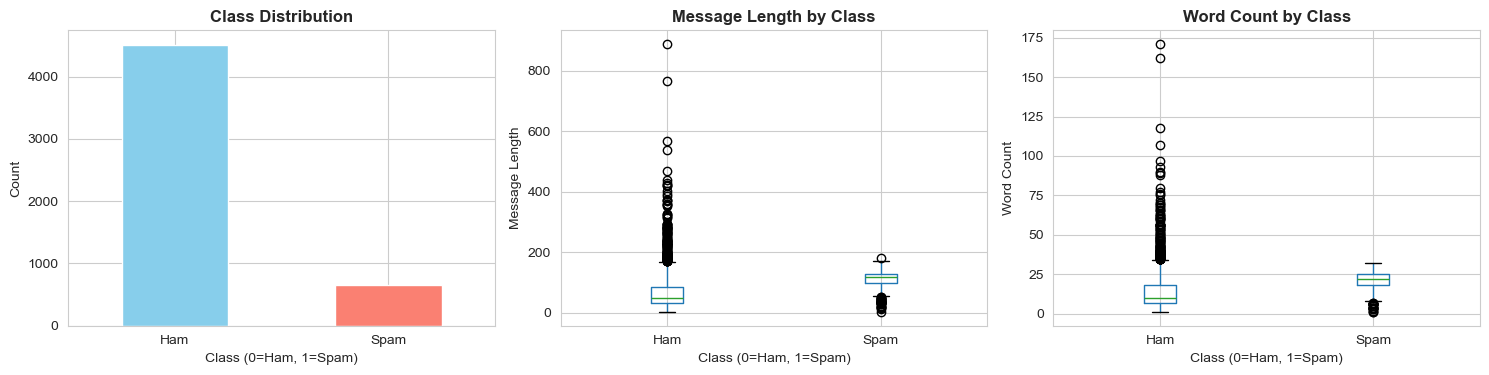


✓ Preprocessing complete!


In [31]:
# Cell 4: Preprocessing + Visualization
def preprocess_data(df):
    """
    Preprocess SMS data:
    - Remove missing values
    - Remove duplicates
    - Clean text
    - Convert labels to binary (0=ham, 1=spam)
    - Add derived features
    """
    df = df.copy()
    
    print("="*60)
    print("PREPROCESSING STEPS")
    print("="*60)
    
    # Remove missing values
    initial_rows = len(df)
    df = df.dropna(subset=['message', 'label'])
    if len(df) < initial_rows:
        print(f"✓ Removed {initial_rows - len(df)} rows with missing values")
    else:
        print(f"✓ No missing values found")
    
    # Remove duplicates
    initial_rows = len(df)
    df = df.drop_duplicates(subset=['message'])
    print(f"✓ Removed {initial_rows - len(df)} duplicate messages")
    
    # Clean text
    print("✓ Cleaning text...")
    df['message'] = df['message'].apply(clean_text)
    
    # Remove empty messages
    initial_rows = len(df)
    df = df[df['message'].str.len() > 0]
    if len(df) < initial_rows:
        print(f"✓ Removed {initial_rows - len(df)} messages that became empty after cleaning")
    
    # Convert labels to binary
    df['label'] = (df['label'] == 'spam').astype(int)
    
    # Add features
    df['message_length'] = df['message'].str.len()
    df['word_count'] = df['message'].str.split().str.len()
    df['avg_word_length'] = df['message_length'] / df['word_count']
    
    return df


df_processed = preprocess_data(df)

print(f"\n{'='*60}")
print("FINAL DATASET SUMMARY")
print(f"{'='*60}")
print(f"Total messages: {len(df_processed)}")
print(f"Ham (0): {(df_processed['label'] == 0).sum()} ({100*(df_processed['label'] == 0).sum()/len(df_processed):.2f}%)")
print(f"Spam (1): {(df_processed['label'] == 1).sum()} ({100*(df_processed['label'] == 1).sum()/len(df_processed):.2f}%)")

print(f"\n{'='*60}")
print("FEATURE STATISTICS BY CLASS")
print(f"{'='*60}")
print("\nMessage Length:")
print(df_processed.groupby('label')['message_length'].describe())
print("\nWord Count:")
print(df_processed.groupby('label')['word_count'].describe())
print("\nAverage Word Length:")
print(df_processed.groupby('label')['avg_word_length'].describe())

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Class distribution
df_processed['label'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Class Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class (0=Ham, 1=Spam)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Ham', 'Spam'], rotation=0)

# Plot 2: Message length distribution
df_processed.boxplot(column='message_length', by='label', ax=axes[1])
axes[1].set_title('Message Length by Class', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class (0=Ham, 1=Spam)')
axes[1].set_ylabel('Message Length')
plt.sca(axes[1])
plt.xticks([1, 2], ['Ham', 'Spam'])

# Plot 3: Word count distribution
df_processed.boxplot(column='word_count', by='label', ax=axes[2])
axes[2].set_title('Word Count by Class', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Class (0=Ham, 1=Spam)')
axes[2].set_ylabel('Word Count')
plt.sca(axes[2])
plt.xticks([1, 2], ['Ham', 'Spam'])

plt.suptitle('')
plt.tight_layout()
plt.show()

print("\n✓ Preprocessing complete!")


## Section 5: Split Data

Split into train (60%), validation (20%), and test (20%) with stratification.

DATA SPLIT SUMMARY
Train: 3100 (60.0%)
Validation: 1033 (20.0%)
Test: 1034 (20.0%)

CLASS DISTRIBUTION ACROSS SPLITS
     Split  Total  Ham  Spam Spam %
     Train   3100 2708   392 12.65%
Validation   1033  903   130 12.58%
      Test   1034  903   131 12.67%


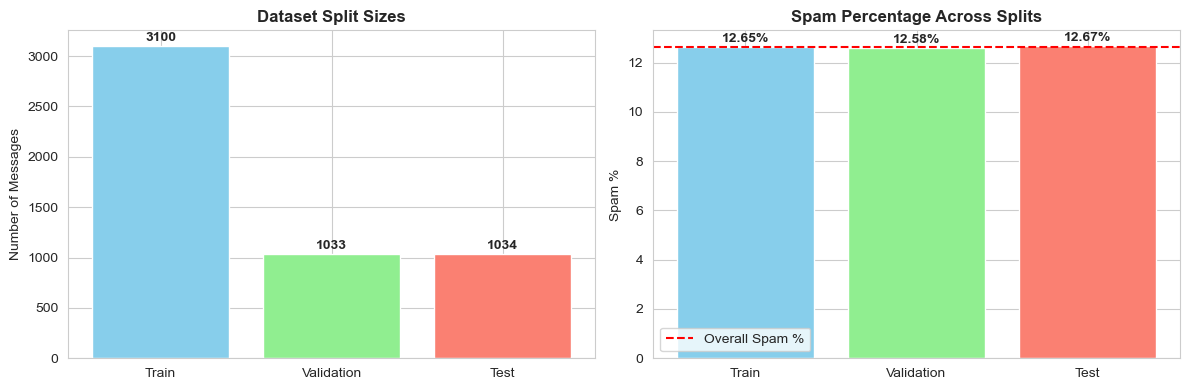


✓ Stratified split complete - class balance maintained!


In [32]:
# Cell 5: Data Splitting + Visualization
def split_data(df, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42):
    """
    Split data into train/validation/test with stratification.
    Default: 60% train, 20% validation, 20% test
    """
    # First split: train vs (val + test)
    train_df, temp_df = train_test_split(
        df,
        test_size=(val_ratio + test_ratio),
        random_state=random_state,
        stratify=df['label']
    )
    
    # Second split: val vs test
    val_df, test_df = train_test_split(
        temp_df,
        test_size=test_ratio / (val_ratio + test_ratio),
        random_state=random_state,
        stratify=temp_df['label']
    )
    
    return train_df, val_df, test_df


# Configurable for DVC versioning - change this for new data versions!
SPLIT_RANDOM_STATE = 28

train_df, val_df, test_df = split_data(
    df_processed,
    train_ratio=0.6, val_ratio=0.2, test_ratio=0.2,
    random_state=SPLIT_RANDOM_STATE
)


print("="*60)
print("DATA SPLIT SUMMARY")
print("="*60)
print(f"Train: {len(train_df)} ({100*len(train_df)/len(df_processed):.1f}%)")
print(f"Validation: {len(val_df)} ({100*len(val_df)/len(df_processed):.1f}%)")
print(f"Test: {len(test_df)} ({100*len(test_df)/len(df_processed):.1f}%)")

print(f"\n{'='*60}")
print("CLASS DISTRIBUTION ACROSS SPLITS")
print(f"{'='*60}")
split_stats = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Total': [len(train_df), len(val_df), len(test_df)],
    'Ham': [(train_df['label']==0).sum(), (val_df['label']==0).sum(), (test_df['label']==0).sum()],
    'Spam': [train_df['label'].sum(), val_df['label'].sum(), test_df['label'].sum()],
    'Spam %': [f"{100*train_df['label'].mean():.2f}%", 
               f"{100*val_df['label'].mean():.2f}%", 
               f"{100*test_df['label'].mean():.2f}%"]
})
print(split_stats.to_string(index=False))

# Visualize split distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Split sizes
split_sizes = [len(train_df), len(val_df), len(test_df)]
axes[0].bar(['Train', 'Validation', 'Test'], split_sizes, color=['skyblue', 'lightgreen', 'salmon'])
axes[0].set_title('Dataset Split Sizes', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Messages')
for i, v in enumerate(split_sizes):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Plot 2: Spam percentage by split
spam_pcts = [100*train_df['label'].mean(), 100*val_df['label'].mean(), 100*test_df['label'].mean()]
axes[1].bar(['Train', 'Validation', 'Test'], spam_pcts, color=['skyblue', 'lightgreen', 'salmon'])
axes[1].set_title('Spam Percentage Across Splits', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Spam %')
axes[1].axhline(y=12.64, color='red', linestyle='--', label='Overall Spam %')
axes[1].legend()
for i, v in enumerate(spam_pcts):
    axes[1].text(i, v + 0.2, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Stratified split complete - class balance maintained!")


## Section 6: Save Splits

Export train, validation, and test sets to CSV files.

In [33]:
train_df.to_csv('data/processed/train.csv', index=False)
val_df.to_csv('data/processed/validation.csv', index=False)
test_df.to_csv('data/processed/test.csv', index=False)

print("="*60)
print("FILES SAVED")
print("="*60)
print("✓ train.csv")
print("✓ validation.csv")
print("✓ test.csv")

FILES SAVED
✓ train.csv
✓ validation.csv
✓ test.csv


In [11]:
def print_target_distribution():
    """Print 0s/1s counts for DVC checkouts"""
    for split, fname in [('Train', '../data/processed/train.csv'),
                        ('Val', '../data/processed/validation.csv'),
                        ('Test', '../data/processed/test.csv')]:
        df = pd.read_csv(fname)
        zeros, ones = (df['label'] == 0).sum(), (df['label'] == 1).sum()
        print(f"{split:12}: 0s={zeros:4}, 1s={ones:4} (spam%={100*ones/(zeros+ones):.1f}%)")

## Section 7: Terminal commands

In [26]:
%%bash
git init
dvc init

Initialized empty Git repository in /Users/amanraj/Developer/AppliedMachineLearning/Assignment_2/.git/
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/treeverse/dvc>


RUN 1: With seed=42

In [27]:
%%bash
dvc add data/raw/raw_data.csv
git add data/raw/.gitignore data/raw/raw_data.csv.dvc
git commit -m "v1: Add raw data"
dvc add data/processed/*.csv
git add data/processed/.gitignore data/processed/*.csv.dvc
git commit -m "v1: Add splits (seed=42)"
dvc status
git log --oneline

⠋ Checking graph



To track the changes with git, run:

	git add data/raw/raw_data.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true
[main (root-commit) 37c78e6] v1: Add raw data
 5 files changed, 12 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore
 create mode 100644 data/raw/.gitignore
 create mode 100644 data/raw/raw_data.csv.dvc


⠋ Checking graph



To track the changes with git, run:

	git add data/processed/train.csv.dvc data/processed/test.csv.dvc data/processed/validation.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true
[main 29438f1] v1: Add splits (seed=42)
 4 files changed, 18 insertions(+)
 create mode 100644 data/processed/.gitignore
 create mode 100644 data/processed/test.csv.dvc
 create mode 100644 data/processed/train.csv.dvc
 create mode 100644 data/processed/validation.csv.dvc
Data and pipelines are up to date.
29438f1 v1: Add splits (seed=42)
37c78e6 v1: Add raw data


In [36]:
print("=== CHECKOUT VERSION 1 ===")
!git checkout HEAD~1
!dvc checkout
print("Version 1 distributions:")


=== CHECKOUT VERSION 1 ===
Note: switching to 'HEAD~1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 29438f1 v1: Add splits (seed=42)
Building workspace index                              |7.00 [00:00,  340entry/s]
Comparing indexes                                    |8.00 [00:00, 4.12kentry/s]
Applying changes                                      |3.00 [00:00,   304file/s]
M       data/processed/test.csv
M       data/processed/train.csv
M       data/processed/validation.csv
Version 1 distributions:


In [28]:
%%bash
echo "=== CURRENT DATA DISTRIBUTIONS ==="
for f in data/processed/*.csv; do
    echo "=== $f ==="
    python -c "
import pandas as pd
df = pd.read_csv('$f')
print(f'0s: {int((df.label==0).sum()):4} | 1s: {int((df.label==1).sum()):4} | Spam%: {100*df.label.mean():.1f}%')
print(df.head(2))
    "
done

=== CURRENT DATA DISTRIBUTIONS ===
=== data/processed/test.csv ===
0s:  903 | 1s:  131 | Spam%: 12.7%
   label                        message  ...  avg_word_length  message_length
0      0        we are both fine thanks  ...         4.600000              23
1      0  aiyar sorry lor forgot tell u  ...         4.833333              29

[2 rows x 6 columns]
=== data/processed/train.csv ===
0s: 2708 | 1s:  392 | Spam%: 12.6%
   label                               message  ...  avg_word_length  message_length
0      0             what you doinghow are you  ...              5.0              25
1      0  good morning princess happy new year  ...              6.0              36

[2 rows x 6 columns]
=== data/processed/validation.csv ===
0s:  903 | 1s:  130 | Spam%: 12.6%
   label  ... message_length
0      1  ...            148
1      0  ...             31

[2 rows x 6 columns]


Now, we change `seed` to `28` , rerun this notebook...

In [34]:
%%bash
dvc add data/processed/*.csv
git add data/processed/*.csv.dvc data/processed/.gitignore
git commit -m "v2: Updated splits (seed=28)"
dvc status
git log --oneline

⠋ Checking graph



To track the changes with git, run:

	git add data/processed/test.csv.dvc data/processed/train.csv.dvc data/processed/validation.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true
[main f5532f1] v2: Updated splits (seed=28)
 3 files changed, 6 insertions(+), 6 deletions(-)
Data and pipelines are up to date.
f5532f1 v2: Updated splits (seed=28)
29438f1 v1: Add splits (seed=42)
37c78e6 v1: Add raw data


In [37]:
print("=== CHECKOUT VERSION 2 ===")
!git checkout main
!dvc checkout
print("Version 2 distributions:")


=== CHECKOUT VERSION 2 ===
Previous HEAD position was 29438f1 v1: Add splits (seed=42)
Switched to branch 'main'
Building workspace index                              |7.00 [00:00,  370entry/s]
Comparing indexes                                    |8.00 [00:00, 3.81kentry/s]
Applying changes                                      |3.00 [00:00,   291file/s]
M       data/processed/test.csv
M       data/processed/train.csv
M       data/processed/validation.csv
Version 2 distributions:


In [35]:
%%bash
echo "=== CURRENT DATA DISTRIBUTIONS ==="
for f in data/processed/*.csv; do
    echo "=== $f ==="
    python -c "
import pandas as pd
df = pd.read_csv('$f')
print(f'0s: {int((df.label==0).sum()):4} | 1s: {int((df.label==1).sum()):4} | Spam%: {100*df.label.mean():.1f}%')
print(df.head(2))
    "
done

=== CURRENT DATA DISTRIBUTIONS ===
=== data/processed/test.csv ===
0s:  903 | 1s:  131 | Spam%: 12.7%
   label  ... message_length
0      0  ...             81
1      0  ...             58

[2 rows x 6 columns]
=== data/processed/train.csv ===
0s: 2708 | 1s:  392 | Spam%: 12.6%
   label  ... message_length
0      0  ...             22
1      0  ...             83

[2 rows x 6 columns]
=== data/processed/validation.csv ===
0s:  903 | 1s:  130 | Spam%: 12.6%
   label  ... message_length
0      0  ...             70
1      0  ...             16

[2 rows x 6 columns]


In [38]:
print("=== FINAL STATUS ===")
!dvc list -R .
!git status --short
!find . -name "*.dvc" | head -5
print(" DVC + Git complete! Data versions tracked.")

=== FINAL STATUS ===
.dvcignore
README.md
data/processed/.gitignore
data/processed/test.csv
data/processed/test.csv.dvc
data/processed/train.csv
data/processed/train.csv.dvc
data/processed/validation.csv
data/processed/validation.csv.dvc
data/raw/.gitignore
data/raw/raw_data.csv
data/raw/raw_data.csv.dvc
mlflow.db
notebooks/mlflow.db
notebooks/mlruns/1/models/m-320cfaa9c52244d9a660d95830a739c2/artifacts/MLmodel
notebooks/mlruns/1/models/m-320cfaa9c52244d9a660d95830a739c2/artifacts/conda.yaml
notebooks/mlruns/1/models/m-320cfaa9c52244d9a660d95830a739c2/artifacts/model.pkl
notebooks/mlruns/1/models/m-320cfaa9c52244d9a660d95830a739c2/artifacts/python_env.yaml
notebooks/mlruns/1/models/m-320cfaa9c52244d9a660d95830a739c2/artifacts/requirements.txt
notebooks/mlruns/1/models/m-6ad32c38577e49918e80faf21af67c12/artifacts/MLmodel
notebooks/mlruns/1/models/m-6ad32c38577e49918e80faf21af67c12/artifacts/conda.yaml
notebooks/mlruns/1/models/m-6ad32c38577e49918e80faf21af67c12/artifacts/model.pkl
noteb

In [46]:
!git status

On branch main
Untracked files:
  (use "git add <file>..." to include in what will be committed)
	README.md
	mlflow.db
	notebooks/

nothing added to commit but untracked files present (use "git add" to track)


**Note:** At this point, we have 2 `.git` files present in the same repo. One in `root` and other in `root/Assignemnt_2`. We must remove one of those before comitting and uploading this into github!

In [47]:
%%bash
echo "=== BEFORE ==="
ls -la | grep git

# REMOVE LOCAL .git (KEEPS DATA SAFE)
rm -rf .git .git-backup 2>/dev/null || echo "No .git found"

echo "=== AFTER ==="
ls -la | grep git  # Should be EMPTY!
pwd


=== BEFORE ===
drwxr-xr-x@ 12 amanraj  staff     384 Feb 18 01:08 .git
=== AFTER ===
/Users/amanraj/Developer/AppliedMachineLearning/Assignment_2


In [48]:
%%bash
# Go up to parent repo
cd ..

echo "=== PARENT GIT STATUS ==="
git status

echo "\n=== Assignment_2 CONTENTS (No .git!) ==="
ls -la Assignment_2/ | grep -E "(git|dvc)"

# Add to parent repo
git add Assignment_2/
git status

git commit -m "Assignment 2: Complete DVC+MLflow (no local .git)"
git push origin main

=== PARENT GIT STATUS ===
On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Assignment_2/.dvc/
	Assignment_2/.dvcignore
	Assignment_2/data/processed/.gitignore
	Assignment_2/data/raw/.gitignore

nothing added to commit but untracked files present (use "git add" to track)
\n=== Assignment_2 CONTENTS (No .git!) ===
drwxr-xr-x@ 6 amanraj  staff     192 Feb 18 00:25 .dvc
-rw-r--r--@ 1 amanraj  staff     139 Feb 18 00:24 .dvcignore
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   Assignment_2/.dvc/.gitignore
	new file:   Assignment_2/.dvc/config
	new file:   Assignment_2/.dvcignore
	new file:   Assignment_2/data/processed/.gitignore
	new file:   Assignment_2/data/raw/.gitignore

[main 8d66c92] Assignment 2: Complete DVC+MLflow (no local .git)
 5 files changed, 10 insertions(+)
 create mode 100644

To https://github.com/AmanRaj2002/AppliedMachineLearning.git
   ee027f2..8d66c92  main -> main


In [49]:
%%bash
cd ..
echo "=== FINAL ADD FROM PARENT ==="
git add Assignment_2/  # Add EVERYTHING
git status

git commit -m "Assignment 2 COMPLETE: DVC(2 versions) + MLflow(3 models) + notebooks"
git push origin main

=== FINAL ADD FROM PARENT ===
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


Everything up-to-date


In [53]:
%%bash
cd ..
echo "=== GitHub Structure ==="
git ls-tree -r --name-only HEAD | grep Assignment_2 | head -15
echo "\n=== DVC Files Tracked ==="
git ls-tree -r --name-only HEAD | grep "\.dvc" | grep Assignment_2
echo "\n SUCCESS: Notebooks + .dvc pointers uploaded!"

=== GitHub Structure ===
Assignment_2/.dvc/.gitignore
Assignment_2/.dvc/config
Assignment_2/.dvcignore
Assignment_2/README.md
Assignment_2/data/processed/.gitignore
Assignment_2/data/processed/test.csv
Assignment_2/data/processed/test.csv.dvc
Assignment_2/data/processed/train.csv
Assignment_2/data/processed/train.csv.dvc
Assignment_2/data/processed/validation.csv
Assignment_2/data/processed/validation.csv.dvc
Assignment_2/data/raw/.gitignore
Assignment_2/data/raw/raw_data.csv
Assignment_2/data/raw/raw_data.csv.dvc
Assignment_2/mlflow.db
\n=== DVC Files Tracked ===
Assignment_2/.dvc/.gitignore
Assignment_2/.dvc/config
Assignment_2/.dvcignore
Assignment_2/data/processed/test.csv.dvc
Assignment_2/data/processed/train.csv.dvc
Assignment_2/data/processed/validation.csv.dvc
Assignment_2/data/raw/raw_data.csv.dvc
\n SUCCESS: Notebooks + .dvc pointers uploaded!
